# Titanic Machine Learning Practice Project
In this practice project, we use machine learning to predict if a given passenger will survive the Titanic crash. This is an ongoing competition on kaggle.com. I did this project to gain knowledge and experience in machine learning and data science. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

## Loading Data

In the code below I load the data and partition the data into variables. Our prediction clastrain_test_splitput into the y variable. Our predictor classes are put into X for training data and X_test for the testing data that we will eventually make our final predictions with. PassengerId, Ticket,
and Name are excluded from the training and testing data because these categories are not expected contribute helpful information for survival prediction. 

I then split the training data into train and validation sets. 

In [2]:
# Importing Data
train = pd.read_csv('../input/titanic/train.csv', index_col='PassengerId')
test = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')

# View aspects of each dataframe
print('Training Data:\n', train.shape)
print('\n\nTesting Data:\n', test.shape)

y = train.Survived

# Selecting all features, excluding PassengerId, Survived, and Name
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
X = train[features]
X_test = test[features]

# Splitting training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

Training Data:
 (891, 11)


Testing Data:
 (418, 10)


## Data Exploration


### Plotting

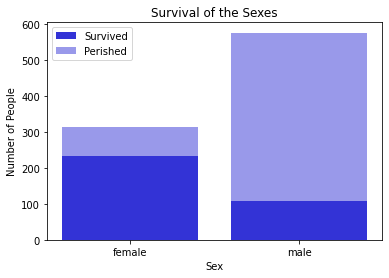

In [3]:
# Method to generate a stacked bar plot of those of each sex that survived and did not
# Grouping data by sex into those that survived vs not, the sex survival count
sc = train.groupby('Sex').Survived.value_counts()
# Labels for sexes
s = sc.index.get_level_values('Sex').unique()

# Bar plot of survived and perished in men and women
fig, ax = plt.subplots()
surv = [sc.loc[('female',1)],sc.loc[('male',1)]]
ax.bar(s, surv, label='Survived', color=(0,0,0.8,0.8))
ax.bar(s, [sc.loc[('female',0)],sc.loc[('male',0)]], bottom=surv, label='Perished', color=(0,0,0.8,0.4))
ax.set_ylabel('Number of People')
ax.set_xlabel('Sex')
ax.set_title('Survival of the Sexes')
ax.legend()
plt.show()

With a p-value of 1.1973570627755645e-58 from the chi-squared test, we see that sex and survival are related.


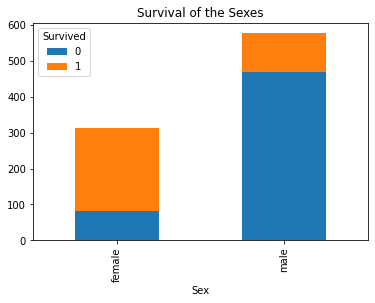

In [4]:
# Simpler method to generate bar plot of those of each sex that survived along with chi-squared value
sex_survive = pd.crosstab(train['Sex'],train['Survived'])
sex_survive.plot.bar(stacked=True, title='Survival of the Sexes')
chi2, p, dof, exp = stats.chi2_contingency(sex_survive)
print('With a p-value of '+str(p)+' from the chi-squared test, we see that sex and survival are related.')

### Missing Values

In [5]:
# Checking for columns with missing values
print('Training Data')
print(X_train.shape)
miss_val_col = X_train.isnull().sum()
print(miss_val_col[miss_val_col>0])

print('\nValidation Data')
print(X_val.shape)
miss_val_col = X_val.isnull().sum()
print(miss_val_col[miss_val_col>0])

print('\nTesting Data')
print(X_test.shape)
miss_val_col = X_test.isnull().sum()
print(miss_val_col[miss_val_col>0])

Training Data
(668, 8)
Age         132
Cabin       519
Embarked      2
dtype: int64

Validation Data
(223, 8)
Age       45
Cabin    168
dtype: int64

Testing Data
(418, 8)
Age       86
Fare       1
Cabin    327
dtype: int64


In [6]:
X = X.drop('Cabin', axis=1)
X_train = X_train.drop('Cabin', axis=1)
X_val = X_val.drop('Cabin', axis=1)
X_test = X_test.drop('Cabin', axis=1)

In [7]:
# Identifying categorical and numerical columns
print(X_train.dtypes)
cat_cols = X_train.columns[X_train.dtypes == 'object']
print('\nUnique values of categorical columns:\n',X_train[cat_cols].nunique())

num_cols = X_train.columns.drop(cat_cols)
print('\nNumerical columns:\n',num_cols)

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

Unique values of categorical columns:
 Sex         2
Embarked    3
dtype: int64

Numerical columns:
 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


## Preprocessing

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Numerical data preprocessing
num_preproc = SimpleImputer(strategy='mean')

# Categorical data preprocesseing
cat_preproc = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OrdinalEncoder(handle_unknown='error'))
])

# Combining numerical and categorical preprocessors
preproc = ColumnTransformer(transformers=[
    ('num',num_preproc,num_cols),
    ('cat',cat_preproc,cat_cols)
])

#### Selecting Best Features

In [9]:
from sklearn.feature_selection import GenericUnivariateSelect, chi2

X_proc = pd.DataFrame(preproc.fit_transform(X))
X_proc.columns = X.columns
X_proc.head()

feat_selector = GenericUnivariateSelect(chi2, mode='fpr')

X_best = feat_selector.fit_transform(X_proc, y)

In [10]:
best_feats = feat_selector.get_feature_names_out()

## Building model and pipeline

In [11]:
from sklearn.ensemble import RandomForestClassifier

first_model = RandomForestClassifier(n_estimators=100, random_state=42)


In [12]:
first_pipeline = Pipeline(steps=[
    ('preprocessor',preproc),
    ('model',first_model)
])

first_pipeline.fit(X_train,y_train)
y_pred = first_pipeline.predict(X_val)

In [13]:
# Computing accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.7982062780269058

## Analyzing for parameter improvements

In [14]:
# Method to build pipeline and compute accuracy based on preprocessing and model parameters
def pipe_acc(num_preprocessor,cat_preprocessor,model):
    
    preproc = ColumnTransformer(transformers=[
        ('num',num_preprocessor,num_cols),
        ('cat',cat_preprocessor,cat_cols)
    ])
    my_pipeline = Pipeline(steps=[
        ('preprocessor',preproc),
        ('model',model)
    ])
    
    my_pipeline.fit(X_train,y_train)
    return accuracy_score(y_val,my_pipeline.predict(X_val))

### Numerical Preprocessors

In [15]:
# Analyzing numerical category preprocessors

# Simple imputer parameters
print('Simple Imputer')
strategy = ['mean','median','most_frequent','constant']
for s in strategy:
    print(s+': %.3f' % (pipe_acc(SimpleImputer(strategy=s), cat_preproc, first_model)))

Simple Imputer
mean: 0.798
median: 0.785
most_frequent: 0.789
constant: 0.789


In [16]:
from sklearn.impute import KNNImputer

#KNN Imputer parameters
print('KNN Imputer')
n_neighbors = [1, 5, 10, 15, 20, 25, 30, 35, 40]
weights = ['uniform', 'distance']
for n in n_neighbors:
    for w in weights:
        print(w+' '+str(n)+' NN: %.3f' % (pipe_acc(KNNImputer(n_neighbors=n,weights=w),cat_preproc,first_model)))

KNN Imputer
uniform 1 NN: 0.776
distance 1 NN: 0.776
uniform 5 NN: 0.789
distance 5 NN: 0.780
uniform 10 NN: 0.803
distance 10 NN: 0.785
uniform 15 NN: 0.816
distance 15 NN: 0.789
uniform 20 NN: 0.789
distance 20 NN: 0.794
uniform 25 NN: 0.789
distance 25 NN: 0.780
uniform 30 NN: 0.789
distance 30 NN: 0.789
uniform 35 NN: 0.776
distance 35 NN: 0.798
uniform 40 NN: 0.789
distance 40 NN: 0.798


#### Final numerical preprocessor

In [17]:
fin_num_preproc = KNNImputer(n_neighbors = 20, weights='uniform')

### Categorical Preprocessors

In [18]:
from sklearn.preprocessing import OrdinalEncoder

# Simple imputer
print('Simple Imputer Tests')
cat_preproc_tester = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])
print('most frequent: %0.3f' % (pipe_acc(fin_num_preproc,cat_preproc_tester,first_model)))

cat_preproc_tester = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])
print('constant: %0.3f' % (pipe_acc(fin_num_preproc,cat_preproc_tester,first_model)))

# Encoder
print('\nEncoder Tests')
cat_preproc_tester = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])
print('one hot: %0.3f' % (pipe_acc(fin_num_preproc,cat_preproc_tester,first_model)))

cat_preproc_tester = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ordinal',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])
print('ordinal: %0.3f' % (pipe_acc(fin_num_preproc,cat_preproc_tester,first_model)))

Simple Imputer Tests
most frequent: 0.803
constant: 0.798

Encoder Tests
one hot: 0.803
ordinal: 0.789


#### Final categorical preprocessor

In [19]:
fin_cat_preproc = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])


### Models

In [20]:
# Random Forest
print("Random Forest\nNumber of Trees")
n_estimators = [10,50,100,150,200,250,300,350,400]
for n in n_estimators:
    print(str(n)+' trees: %0.3f' % (pipe_acc(fin_num_preproc,fin_cat_preproc,
                                            RandomForestClassifier(n_estimators=n,random_state=42))))

print("\nCriterion")
print('gini: %0.3f' % (pipe_acc(fin_num_preproc,fin_cat_preproc,
                                            RandomForestClassifier(n_estimators=100,criterion='gini',random_state=42))))
print('entropy: %0.3f' % (pipe_acc(fin_num_preproc,fin_cat_preproc,
                                            RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=42))))

print("\nMax Depth")
max_depth = [None,2,4,6,8,10,12,14,16,18,20]
for m in max_depth:
    print(str(m)+' max depth: %0.3f' % (pipe_acc(fin_num_preproc,fin_cat_preproc,
                                            RandomForestClassifier(n_estimators=100,max_depth=m,random_state=42))))

print("\nMin Samples Split")
min_samples_split = [0.01,0.1,0.5,2,4,6,8,10,12,14,16,18,20]
for m in min_samples_split:
    print(str(m)+' min samples split: %0.3f' % (pipe_acc(fin_num_preproc,fin_cat_preproc,
                                                         RandomForestClassifier(n_estimators=100,min_samples_split=m,max_depth=8,random_state=42))))

print("\nMin Samples Leaf")
min_samples_leaf = [1,2,4,6,8,10,12,14,16,18,20]
for m in min_samples_leaf:
    print(str(m)+' min samples leaf: %0.3f' % (pipe_acc(fin_num_preproc,fin_cat_preproc,
                                                         RandomForestClassifier(n_estimators=100,min_samples_leaf=m,max_depth=8,random_state=42))))

Random Forest
Number of Trees
10 trees: 0.762
50 trees: 0.785
100 trees: 0.803
150 trees: 0.794
200 trees: 0.785
250 trees: 0.794
300 trees: 0.798
350 trees: 0.794
400 trees: 0.789

Criterion
gini: 0.803
entropy: 0.794

Max Depth
None max depth: 0.803
2 max depth: 0.785
4 max depth: 0.812
6 max depth: 0.816
8 max depth: 0.821
10 max depth: 0.816
12 max depth: 0.798
14 max depth: 0.798
16 max depth: 0.798
18 max depth: 0.789
20 max depth: 0.803

Min Samples Split
0.01 min samples split: 0.816
0.1 min samples split: 0.812
0.5 min samples split: 0.785
2 min samples split: 0.821
4 min samples split: 0.816
6 min samples split: 0.816
8 min samples split: 0.812
10 min samples split: 0.821
12 min samples split: 0.816
14 min samples split: 0.812
16 min samples split: 0.816
18 min samples split: 0.821
20 min samples split: 0.812

Min Samples Leaf
1 min samples leaf: 0.821
2 min samples leaf: 0.807
4 min samples leaf: 0.825
6 min samples leaf: 0.812
8 min samples leaf: 0.821
10 min samples leaf: 

In [21]:
fin_forest_model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)

fin_preproc = ColumnTransformer(transformers=[
    ('num',fin_num_preproc,num_cols),
    ('cat',fin_cat_preproc,cat_cols)
])

fin_forest_pipeline = Pipeline(steps=[
    ('preprocessor',fin_preproc),
    ('model',fin_forest_model)
])

## Cross-Validation

In [22]:
# Evaluating model with cross-validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(fin_forest_pipeline, X, y,
                         cv=5,
                         scoring='accuracy')

print("Average accuracy:\n", scores.mean())

Average accuracy:
 0.831680371602536


## XGBoost

In [23]:
X_train_proc = pd.DataFrame(fin_preproc.fit_transform(X_train))
X_val_proc = pd.DataFrame(fin_preproc.fit_transform(X_val))

In [24]:
from xgboost import XGBClassifier

def xgb_acc(xgb_model):
    xgb_model.fit(X_train_proc, y_train)

    y_xgbpred = xgb_model.predict(X_val_proc)
    
    return accuracy_score(y_val,y_xgbpred)

In [25]:
# XGBost Parameter Analyzation
print('Default Parameters Accuracy')
print('Default: %0.3f' %(xgb_acc(XGBClassifier(verbosity=0,
                                               use_label_encoder=False))))    

print('\nNumber of Estimators')
for n in range(5,45,5):
    print('%0.1f trees: %0.3f' % (n,xgb_acc(XGBClassifier(n_estimators=n,
                                                               verbosity=0,
                                                               use_label_encoder=False))))
#n_estimators = 20


print('\nMax Depth')
for n in range(2,21,2):
    print('%0.1f max depth: %0.3f' % (n,xgb_acc(XGBClassifier(max_depth=n,
                                                              n_estimators=5,
                                                              verbosity=0,
                                                              use_label_encoder=False))))
#max_depth = 6

print('\nLearning Rate')
for l in np.arange(0.1,1,0.1):
    print('%0.1f max depth: %0.3f' % (l,xgb_acc(XGBClassifier(learning_rate=l,
                                                              n_estimators=5,
                                                              verbosity=0,
                                                              use_label_encoder=False))))


Default Parameters Accuracy
Default: 0.767

Number of Estimators
5.0 trees: 0.825
10.0 trees: 0.812
15.0 trees: 0.821
20.0 trees: 0.798
25.0 trees: 0.785
30.0 trees: 0.780
35.0 trees: 0.771
40.0 trees: 0.771

Max Depth
2.0 max depth: 0.776
4.0 max depth: 0.821
6.0 max depth: 0.825
8.0 max depth: 0.812
10.0 max depth: 0.807
12.0 max depth: 0.798
14.0 max depth: 0.798
16.0 max depth: 0.798
18.0 max depth: 0.798
20.0 max depth: 0.798

Learning Rate
0.1 max depth: 0.830
0.2 max depth: 0.830
0.3 max depth: 0.825
0.4 max depth: 0.816
0.5 max depth: 0.803
0.6 max depth: 0.807
0.7 max depth: 0.830
0.8 max depth: 0.803
0.9 max depth: 0.821


## BREAK

## Final Model

In [26]:

fin_model = fin_forest_model

fin_preproc = ColumnTransformer(transformers=[
    ('num',fin_num_preproc,num_cols),
    ('cat',fin_cat_preproc,cat_cols)
])

fin_pipeline = Pipeline(steps=[
    ('preprocessor',fin_preproc),
    ('model',fin_model)
])

fin_pipeline.fit(X_train,y_train)
pred_test = fin_pipeline.predict(X_test)

## Saving output for submission

In [27]:
output = pd.DataFrame({'PassengerId': test.index,
                       'Survived': pred_test})
output.to_csv('submission.csv', index=False)

In [28]:
s = pd.read_csv('./submission.csv')
s.shape

(418, 2)